In [1]:
## general libraries 
import os,sys,glob
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
import dask.array as da

In [3]:
import math

In [4]:
import time

In [5]:
# for plots
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

## ML libraries
# tensorflow
import tensorflow as tf
from tensorflow import keras
#print('tensorflow version:', tf.__version__) 

# keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense
from keras.utils.vis_utils import plot_model #CHANGE
#from keras.utils import plot_model #LAPTOP
import keras.backend as K
from tensorflow.python.training import checkpoint_utils as cp

#Extra libraries
from ann_visualizer.visualize import ann_viz
from itertools import chain

from mpl_toolkits import mplot3d
from sympy import symbols 
from sympy.utilities.lambdify import lambdify

print(f'Using Python  = {sys.version.split()[0]}')
print(f'Tensorflow    = {tf.__version__}')
print(f'Keras Version = {keras.__version__}')

Using Python  = 3.8.8
Tensorflow    = 2.8.0
Keras Version = 2.8.0


data_path = '//storage/ddiaz/2021/ATOC557rm/project/nonlinear_albedo_feedback_nn/era5_grid1_data/'


variables = ['tsr','tisr','tciw','tclw','tcwv','hcc','mcc','lcc','sp','tco3','fal']

TSR = xr.open_dataset(data_path+'TSR_era5.nc')

time = TSR.time

lon = TSR.longitude
lat = TSR.latitude

numlon = len(lon)
numlat = len(lat)
numy = len(time)
nvar = len(variables)

In [6]:
path = '//storage/ddiaz/2023/myProject/data/'
file = 'era5_monthly_avg_sl_2005-2020_tisr_tciw_tclw_tcwv_hcc_mcc_lcc_sp_tco3_fal_tsr.nc'
#file = 'era5_monthly_avg_pl_2005-2020_cc_ciwc_clwc.nc'
#file = 'era5_hourly_062016_pressurelevels.nc'
#file = 'era5_hourly_062016_single.nc'
#file = 'ALIIAera5_hourly_062016_single.nc'

In [7]:
xrr_sl = xr.open_dataset(path+file)
#even years for trainning
xrr_sl_even = xrr_sl.sel(time = ['2016','2018','2020'])#time=slice('2015','2020'))
#odd years for testing
x_rr_sl_odd = xrr_sl.sel(time = ['2015','2017','2019'])

In [8]:
xrr_sl

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 192)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2005-01-01 2005-02-01 ... 2020-12-01
Data variables:
    fal        (time, latitude, longitude) float32 ...
    hcc        (time, latitude, longitude) float32 ...
    lcc        (time, latitude, longitude) float32 ...
    mcc        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    tisr       (time, latitude, longitude) float32 ...
    tsr        (time, latitude, longitude) float32 ...
    tciw       (time, latitude, longitude) float32 ...
    tclw       (time, latitude, longitude) float32 ...
    tco3       (time, latitude, longitude) float32 ...
    tcwv       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-04-03 23:21:47 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [9]:
df_train = xrr_sl_even.to_dataframe()

In [10]:
#To convert to W m-2 , the accumulated values should be divided by the accumulation period expressed in seconds
df_train.tisr = df_train.tisr/24/3600
df_train.tsr =df_train.tsr/24/3600

In [11]:
df_train

fal       hcc       lcc       mcc  \
latitude longitude time                                                 
 90.0    0.00      2016-01-01  0.765611  0.398443  0.765767  0.409581   
                   2018-01-01  0.764668  0.086725  0.799246  0.303552   
                   2020-01-01  0.765586  0.477839  0.806830  0.533519   
         0.25      2016-01-01  0.765611  0.398443  0.765767  0.409581   
                   2018-01-01  0.764668  0.086725  0.799246  0.303552   
...                                 ...       ...       ...       ...   
-90.0    359.50    2018-01-01  0.849990  0.050442  0.335846  0.307281   
                   2020-01-01  0.849990  0.062914  0.349351  0.316068   
         359.75    2016-01-01  0.849990  0.040610  0.225138  0.196559   
                   2018-01-01  0.849990  0.050442  0.335846  0.307281   
                   2020-01-01  0.849990  0.062914  0.349351  0.316068   

                                          sp        tisr         tsr  \
latitude longitude time                                                
 90.0    0.00      2016-01-01  101628.156250    0.000000    0.000000   
                   2018-01-01  102284.835938    0.000000    0.000000   
                   2020-01-01  100914.531250    0.000000    0.000000   
         0.25      2016-01-01  101628.156250    0.000000    0.000000   
                   2018-01-01  102284.835938    0.000000    0.000000   
...                                      ...         ...         ...   
-90.0    359.50    2018-01-01   69167.093750  494.959625  142.958145   
                   2020-01-01   69450.132812  497.031952  143.978119   
         359.75    2016-01-01   68781.375000  497.342407  140.764481   
                   2018-01-01   69167.093750  494.959625  142.958145   
                   2020-01-01   69450.132812  497.031952  143.978119   

                                   tciw      tclw      tco3      tcwv  
latitude longitude time                                                
 90.0    0.00      2016-01-01  0.027079  0.009081  0.007087  2.872501  
                   2018-01-01  0.008409  0.008280  0.007329  2.336403  
                   2020-01-01  0.022622  0.001376  0.006742  2.076271  
         0.25      2016-01-01  0.027079  0.009081  0.007087  2.872501  
                   2018-01-01  0.008409  0.008280  0.007329  2.336403  
...                                 ...       ...       ...       ...  
-90.0    359.50    2018-01-01  0.006861  0.000203  0.006309  1.010857  
                   2020-01-01  0.004444  0.000036  0.006408  0.989368  
         359.75    2016-01-01  0.004922  0.000012  0.006105  0.783524  
                   2018-01-01  0.006861  0.000203  0.006309  1.010857  
                   2020-01-01  0.004444  0.000036  0.006408  0.989368  

[3114720 rows x 11 columns]

#### We define input variables

In [12]:
# we use da.from_array() instead of np.array() since it uses less memory

tisr = np.array(df_train.tisr) 
tciw = np.array(df_train.tciw)
tclw = np.array(df_train.tclw)
tcwv = np.array(df_train.tcwv)
lcc = np.array(df_train.lcc)
mcc = np.array(df_train.mcc)
hcc = np.array(df_train.hcc)
sp = np.array(df_train.sp)
tco3 = np.array(df_train.tco3)
fal = np.array(df_train.fal)

In [13]:
tisr

array([  0.     ,   0.     ,   0.     , ..., 497.3424 , 494.95963,
       497.03195], dtype=float32)

#### Output variable

In [14]:
tsr = np.array(df_train.tsr)

#### Min Max normalization  

In [15]:
def MinMaxNorm(x,a,b):
    ''' Min-max normalization method between a specified range
        Normalization range = [a,b]
        x = input data
        a = lower range
        b = upper range 
        This method normalizes the input and output variables for the training of the NN'''
    
    n = (b-a)*(x-np.min(x))/(np.max(x)-np.min(x))+a
    return n

def MinMaxInverse(n,a,b,df):
    ''' Min-max inverse transform method 
        n = normalized data between [a,b]
        a = lower range
        b = upper range
        
        This method transforms the range of the predicted values using the NN, 
        from -1 to 1 to the correct range of the magnitude of the fnt of sw at TOA'''
    
    #we define the min and max values from the training dataset
    max_val = np.round(np.max(df.tsr),2)
    min_val = np.round(np.min(df.tsr),2)
    
    x = (n-a)*(max_val-min_val)/(b-a)+min_val
    return x

In [16]:
vars_list = [tisr, tciw, tclw, tcwv, lcc, mcc, hcc, sp, tco3 , fal]
vars_list_str = ['tisr', 'tciw', 'tclw', 'tcwv', 'lcc', 'mcc', 'hcc', 'sp', 'tco3' , 'fal']

type(vars_list)

#we combine the input variables into one merged array
merged_array = da.stack((vars_list), axis=1) #np.stack((vars_list), axis=1)

xx = merged_array
yy = tsr

In [17]:
max_val = np.round(np.max(tsr),2)
min_val = np.round(np.min(tsr),2)

# Normalization range [a,b]
#We set the normalization rate to be between -1 and 1, since the activation function (tanh) has the same range
a = -1
b = 1

nrmlzd_vars_list = []
for x in vars_list:    
    n = MinMaxNorm(x,a,b)
    nrmlzd_vars_list.append(n)

In [18]:
#we combine the input variables into one merged array
merged_array = np.stack((nrmlzd_vars_list), axis=1) #da.stack((nrmlzd_vars_list), axis=1)

In [19]:
len(nrmlzd_vars_list[0])

3114720

da.from_array?

### we define here the input and output variables for the NN

In [20]:
xx = merged_array
yy = MinMaxNorm(tsr,a,b) #we normalize the output

#### new early stopping method

In [21]:
from keras.callbacks import Callback

class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current <= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

#####  Function to train the NN

In [22]:
def runNN(x_values,y_real,alpha, iterations,shape_input,nodesLayer1, nodesLayer2, act_function1, act_function2, 
          earlyStopping, patienceEpochs, loss_thr ,dpii=80):
    
    start_time = time.time()
    
    # defining the tensors for the NN
    x=tf.constant(x_values) #albedo
    y=tf.constant(y_real) # prtrbd.fnt_sw_toa.to_numpy()
    
    # define the model
    model = tf.keras.Sequential(name='Sequential_NN')
    
    if nodesLayer2 == 0:
        layer1 = Dense(nodesLayer1,activation=act_function1 ,input_shape=[shape_input], name='hiddenLayer1') #11 relu
        output = Dense(1, name='output')

        model.add(layer1)
        model.add(output)
    
    else:
        layer1 = Dense(nodesLayer1,activation=act_function1 ,input_shape=[shape_input], name='hiddenLayer1') #11 relu
        layer2 = Dense(nodesLayer2,activation=act_function2, name='hiddenLayer2')
        output = Dense(1, name='output')

        model.add(layer1)
        model.add(layer2)
        model.add(output)

    # compile the model
    model.compile(loss='mse',
                  optimizer= tf.keras.optimizers.Adam(learning_rate=alpha), 
                  metrics=['accuracy'])

    # display the model
    model.summary()
    ann_viz(model, filename='figure_NN', title="Neural network")
    
    # save hyperparameters
    weights_dict = {}

    weight_callback = tf.keras.callbacks.LambdaCallback \
    ( on_epoch_end=lambda epoch, logs: weights_dict.update({epoch:model.get_weights()}))
    
    if earlyStopping==0:
        # fit the model
        history = model.fit( x, y, epochs=iterations, callbacks=[weight_callback],verbose=True)
    
    if earlyStopping== 1:
        #adding a callback to stop training 
        #es = EarlyStoppingByLossVal(monitor='loss', value=loss_thr, verbose=True)
        es = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1, mode='min', 
                                             patience=patienceEpochs)#min_delta=0.00001, start_from_epoch=10)
        # NEED TO CHECK THIS
        #es = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1, mode='min', 
                                              #baseline=loss_thr, min_delta=0.000001, patience=patienceEpochs)#min_delta=0.00001, start_from_epoch=10)

        # fit the model
        history = model.fit( x, y, epochs=iterations, callbacks=[weight_callback,es],verbose=True)
        #print(history.history)
    
    # get the learning rate value of the model
    lr= K.eval(model.optimizer.lr)

    # plot cost function
    plt.figure(figsize=(8,6),dpi=dpii)
    history_df = pd.DataFrame(history.history)

    plt.plot(history_df['loss'], label='cost')
    plt.yscale('log')

    plt.title('Training cost function with learning rate = '+ str(lr))
    plt.legend()
    plt.show()
    
    print("--- %s seconds ---" % (time.time() - start_time))
    
    return(model,history_df,weights_dict)

### Training and testing with all data

In [23]:
tf.random.set_seed(6)

lr = 0.001
itrtns = 90000
shp_inpt = merged_array.shape[1]
ndsLyr1 =15
ndsLyr2 =0
act_fnctn1 = 'tanh'
act_fnctn2 = 0
earlyStppng = 1 # No = 0 , Yes = 1
ptnce = 100 #100
lossTHR = 0.00002 #0.00003 

In [24]:
merged_array.shape

(3114720, 10)

Patience = 500 for bivariate case

In [25]:
model,history_df,weights_dict = runNN(xx, yy,
                                    alpha=lr,
                                    iterations=itrtns,
                                    shape_input=shp_inpt,
                                    nodesLayer1=ndsLyr1,
                                    nodesLayer2=ndsLyr2,
                                    act_function1=act_fnctn1,
                                    act_function2=act_fnctn2,
                                    earlyStopping=earlyStppng,   
                                    patienceEpochs=ptnce,
                                    loss_thr=lossTHR ) #we define the loss threshold but we are not using it

Model: "Sequential_NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hiddenLayer1 (Dense)        (None, 15)                165       
                                                                 
 output (Dense)              (None, 1)                 16        
                                                                 
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________
Epoch 1/90000
97335/97335 [==============================] - 121s 1ms/step - loss: 6.8551e-04 - accuracy: 3.2106e-07
Epoch 2/90000
97335/97335 [==============================] - 120s 1ms/step - loss: 4.0802e-04 - accuracy: 3.2106e-07
Epoch 3/90000
97335/97335 [==============================] - 117s 1ms/step - loss: 3.9503e-04 - accuracy: 3.2106e-07
Epoch 4/90000
97335/97335 [==============================] - 118s 1ms/step - loss: 3.8604e-04 - accu

97335/97335 [==============================] - 116s 1ms/step - loss: 3.4751e-04 - accuracy: 3.2106e-07
Epoch 65/90000
97335/97335 [==============================] - 116s 1ms/step - loss: 3.4742e-04 - accuracy: 3.2106e-07
Epoch 66/90000
97335/97335 [==============================] - 116s 1ms/step - loss: 3.4745e-04 - accuracy: 3.2106e-07
Epoch 67/90000
97335/97335 [==============================] - 116s 1ms/step - loss: 3.4725e-04 - accuracy: 3.2106e-07
Epoch 68/90000
97335/97335 [==============================] - 116s 1ms/step - loss: 3.4707e-04 - accuracy: 3.2106e-07
Epoch 69/90000
97335/97335 [==============================] - 115s 1ms/step - loss: 3.4708e-04 - accuracy: 3.2106e-07
Epoch 70/90000
97335/97335 [==============================] - 114s 1ms/step - loss: 3.4720e-04 - accuracy: 3.2106e-07
Epoch 71/90000
97335/97335 [==============================] - 114s 1ms/step - loss: 3.4703e-04 - accuracy: 3.2106e-07
Epoch 72/90000
97335/97335 [==============================] - 114s 1ms/

97335/97335 [==============================] - 118s 1ms/step - loss: 3.4490e-04 - accuracy: 3.2106e-07
Epoch 134/90000
97335/97335 [==============================] - 118s 1ms/step - loss: 3.4473e-04 - accuracy: 3.2106e-07
Epoch 135/90000
97335/97335 [==============================] - 118s 1ms/step - loss: 3.4478e-04 - accuracy: 3.2106e-07
Epoch 136/90000
97335/97335 [==============================] - 117s 1ms/step - loss: 3.4477e-04 - accuracy: 3.2106e-07
Epoch 137/90000
97335/97335 [==============================] - 118s 1ms/step - loss: 3.4508e-04 - accuracy: 3.2106e-07
Epoch 138/90000
97335/97335 [==============================] - 118s 1ms/step - loss: 3.4467e-04 - accuracy: 3.2106e-07
Epoch 139/90000
97335/97335 [==============================] - 118s 1ms/step - loss: 3.4492e-04 - accuracy: 3.2106e-07
Epoch 140/90000
97335/97335 [==============================] - 118s 1ms/step - loss: 3.4474e-04 - accuracy: 3.2106e-07
Epoch 141/90000
97335/97335 [==============================] - 1

Epoch 202/90000
97335/97335 [==============================] - 120s 1ms/step - loss: 3.4355e-04 - accuracy: 3.2106e-07
Epoch 203/90000
97335/97335 [==============================] - 120s 1ms/step - loss: 3.4363e-04 - accuracy: 3.2106e-07
Epoch 204/90000
97335/97335 [==============================] - 255s 3ms/step - loss: 3.4341e-04 - accuracy: 3.2106e-07
Epoch 205/90000
97335/97335 [==============================] - 154s 2ms/step - loss: 3.4378e-04 - accuracy: 3.2106e-07
Epoch 206/90000
97335/97335 [==============================] - 117s 1ms/step - loss: 3.4362e-04 - accuracy: 3.2106e-07
Epoch 207/90000
97335/97335 [==============================] - 119s 1ms/step - loss: 3.4346e-04 - accuracy: 3.2106e-07
Epoch 208/90000
97335/97335 [==============================] - 117s 1ms/step - loss: 3.4372e-04 - accuracy: 3.2106e-07
Epoch 209/90000
97335/97335 [==============================] - 116s 1ms/step - loss: 3.4381e-04 - accuracy: 3.2106e-07
Epoch 210/90000
97335/97335 [===================

97335/97335 [==============================] - 121s 1ms/step - loss: 3.4391e-04 - accuracy: 3.2106e-07
Epoch 271/90000
97335/97335 [==============================] - 120s 1ms/step - loss: 3.4346e-04 - accuracy: 3.2106e-07
Epoch 272/90000
97335/97335 [==============================] - 120s 1ms/step - loss: 3.4380e-04 - accuracy: 3.2106e-07
Epoch 273/90000
97335/97335 [==============================] - 120s 1ms/step - loss: 3.4376e-04 - accuracy: 3.2106e-07
Epoch 274/90000
97335/97335 [==============================] - 120s 1ms/step - loss: 3.4368e-04 - accuracy: 3.2106e-07
Epoch 275/90000
97335/97335 [==============================] - 120s 1ms/step - loss: 3.4363e-04 - accuracy: 3.2106e-07
Epoch 276/90000
97335/97335 [==============================] - 120s 1ms/step - loss: 3.4355e-04 - accuracy: 3.2106e-07
Epoch 277/90000
97335/97335 [==============================] - 120s 1ms/step - loss: 3.4360e-04 - accuracy: 3.2106e-07
Epoch 278/90000
97335/97335 [==============================] - 1

Epoch 339/90000
97335/97335 [==============================] - 121s 1ms/step - loss: 3.4366e-04 - accuracy: 3.2106e-07
Epoch 340/90000
97335/97335 [==============================] - 119s 1ms/step - loss: 3.4349e-04 - accuracy: 3.2106e-07
Epoch 341/90000
83309/97335 [========================>.....] - ETA: 16s - loss: 3.4330e-04 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [27]:
13427/60/60

3.729722222222222

In [28]:
len(history_df.values)

114

In [29]:
history_df['loss']

0      0.000686
1      0.000408
2      0.000395
3      0.000386
4      0.000379
         ...   
109    0.000345
110    0.000345
111    0.000345
112    0.000345
113    0.000345
Name: loss, Length: 114, dtype: float64

In [30]:
history_df['accuracy']

0      3.210561e-07
1      3.210561e-07
2      3.210561e-07
3      3.210561e-07
4      3.210561e-07
           ...     
109    3.210561e-07
110    3.210561e-07
111    3.210561e-07
112    3.210561e-07
113    3.210561e-07
Name: accuracy, Length: 114, dtype: float64

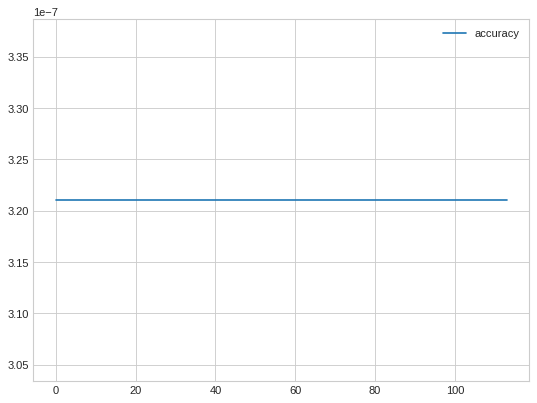

In [32]:
# plot accuracy
plt.figure(figsize=(8,6),dpi=80)

plt.plot(history_df['accuracy'], label='accuracy')
#plt.yscale('log')

#plt.title('Training cost function with learning rate = '+ str(lr))
plt.legend()
plt.show()

plt.figure(figsize=(8,6),dpi=300)

plt.plot(history_df['loss'], label='cost')
plt.yscale('log')

plt.title('Training cost function with learning rate = '+ str(lr))
plt.legend()
plt.show()

In [33]:
model.trainable_weights

[<tf.Variable 'hiddenLayer1/kernel:0' shape=(10, 15) dtype=float32, numpy=
 array([[ 1.8971653e+00,  7.2076865e-03,  1.3395648e+00, -9.3587661e-01,
         -1.3341464e+00,  2.0890689e+00,  5.9132481e-01, -5.1614994e-01,
          2.5736036e+00,  7.1563083e-01, -1.7127584e-03, -1.6085314e+00,
          2.7238293e+00,  1.8528991e+00,  4.7927269e-01],
        [-2.0124910e+00, -2.7749145e-02, -1.4538006e-01, -6.2378418e-02,
         -3.3300426e+00, -1.5277101e-01, -9.9358213e-01,  3.6493441e-01,
          2.4511293e-02, -3.7506938e-01, -4.2241747e-03,  9.2347693e-01,
         -4.8479334e-01, -1.2224804e+00, -1.1094178e+00],
        [ 3.3782260e+00,  2.1920949e-02,  2.6883978e-02,  2.9567230e-01,
          1.9638637e+00,  7.1174204e-01, -3.6073163e-01, -4.3833664e-01,
         -7.2360450e-01,  8.8596535e-01,  7.8291530e-03,  2.2798080e+00,
         -3.6765292e-01,  6.7599730e+00, -6.1316085e-01],
        [-6.6077757e-01, -1.5717758e-03, -6.7549489e-02, -9.8088622e-02,
          5.1208987e+

#### Function to build the NN equation from the weight and biases outputs

In [34]:
nds_num = ndsLyr1
inpt_num = shp_inpt
inpt_list = vars_list_str
act_func = 'tanh'

# temp list as a container for each layer formulas
formula_list = []
frml_eqn = []
y_str = []
for ii in np.arange(len(model.layers)):
    # get ith Keras layer's weights and biases
    layer = model.layers[ii]
    WB = layer.get_weights()

    #WB[0].shape = (2,2)
    # empty text string to which concatenate current layer formula parts
    formula = ''
    if ii==0:
        
        for jj in np.arange(nds_num):
            weights = []
            all_terms = []
            
            for kk in np.arange(inpt_num):
                cur_weight = WB[0][kk][jj]
                cur_bias = WB[1][jj]
                weights.append(cur_weight)
                # build formula for this layer
                term = (str(np.round(weights[kk],2))+'*'+inpt_list[kk]+'+' )
                all_terms.append(term)
                
            bias = str(np.round(cur_bias,2))
            all_terms.append(bias)
            
            formula_list.append(all_terms)  
            


    elif ii == (len(model.layers)-1):
        for ll in np.arange(nds_num):
            act_term = ''
            for item in formula_list[ll]:
                act_term += str(item)
            y_str.append( str(np.round(WB[0][ll],2).squeeze()) + '*(np.'+ act_func+ '(' + act_term +'))+' )
               
        y_str.append(str(np.round(WB[1][0],2).squeeze()) )

equation = ''
for item in y_str:
    equation += str(item)

# make some cleanings
equation = equation.replace('+-','-')
equation = equation.replace('+*0.0*','')
equation = equation.replace('-*0.0*','')
str_equation = equation.replace('*','') 
str_equation = str_equation.replace('np.','') 

    
print(str_equation)

-0.03(tanh(1.9tisr-2.01tciw+3.38tclw-0.66tcwv+0.14lcc+1.69mcc+0.36hcc+1.37sp+0.21tco3+1.53fal+0.82))+0.0(tanh(0.01tisr-0.03tciw+0.02tclw-0.0tcwv+0.0lcc-0.01mcc+0.0hcc+0.01sp+0.02tco3+0.01fal+0.0))+0.35(tanh(1.34tisr-0.15tciw+0.03tclw-0.07tcwv-0.03lcc+0.12mcc+0.02hcc+0.1sp-0.0tco3+0.31fal+0.86))-0.36(tanh(-0.94tisr-0.06tciw+0.3tclw-0.1tcwv+0.29lcc+0.23mcc+0.01hcc+0.14sp-0.08tco3+0.56fal+0.86))-0.03(tanh(-1.33tisr-3.33tciw+1.96tclw+5.12tcwv+0.67lcc+0.72mcc+0.29hcc-1.46sp+0.34tco3-2.16fal+2.58))+0.17(tanh(2.09tisr-0.15tciw+0.71tclw+0.22tcwv-0.07lcc-0.8mcc-0.04hcc-0.38sp-1.36tco3-1.29fal-3.84))+0.06(tanh(0.59tisr-0.99tciw-0.36tclw+1.77tcwv-0.01lcc-0.31mcc-0.21hcc-1.21sp+0.29tco3+0.11fal+0.17))+0.36(tanh(-0.52tisr+0.36tciw-0.44tclw+1.4tcwv+0.21lcc+0.22mcc+0.03hcc+0.36sp-0.08tco3-0.85fal+2.85))-0.06(tanh(2.57tisr+0.02tciw-0.72tclw+0.43tcwv-0.57lcc+1.54mcc+1.2hcc+0.55sp-0.1tco3-0.34fal-4.67))+0.12(tanh(0.72tisr-0.38tciw+0.89tclw+0.05tcwv+0.32lcc+0.1mcc+0.05hcc+0.01sp+0.03tco3-0.83fal+0.69))-0

#### Testing with odd numbers 

In [38]:
#predictions
xx2 = merged_array
prdctns=model.predict(xx2)
#inverse transform
prdctnss = MinMaxInverse(prdctns,a,b,df_train)

In [32]:
df['nn_prdctns'] = prdctnss

In [37]:
MBE = np.mean(prdctnss-df.tsr.values)
np.round(MBE,4)

-0.397

In [38]:
I = df.tisr #(df.eff_tau_ice+df.eff_tau_liq)
II = df.tciw #(df.eff_tau_ice+df.eff_tau_liq)*df.albedo
III = df.tclw
IV = df.tcwv
V = df.lcc
VII = df.mcc
VIII = df.hcc
IX = df.sp
X = df.tco3
XI = df.fal

Y = df.tsr #z_interp

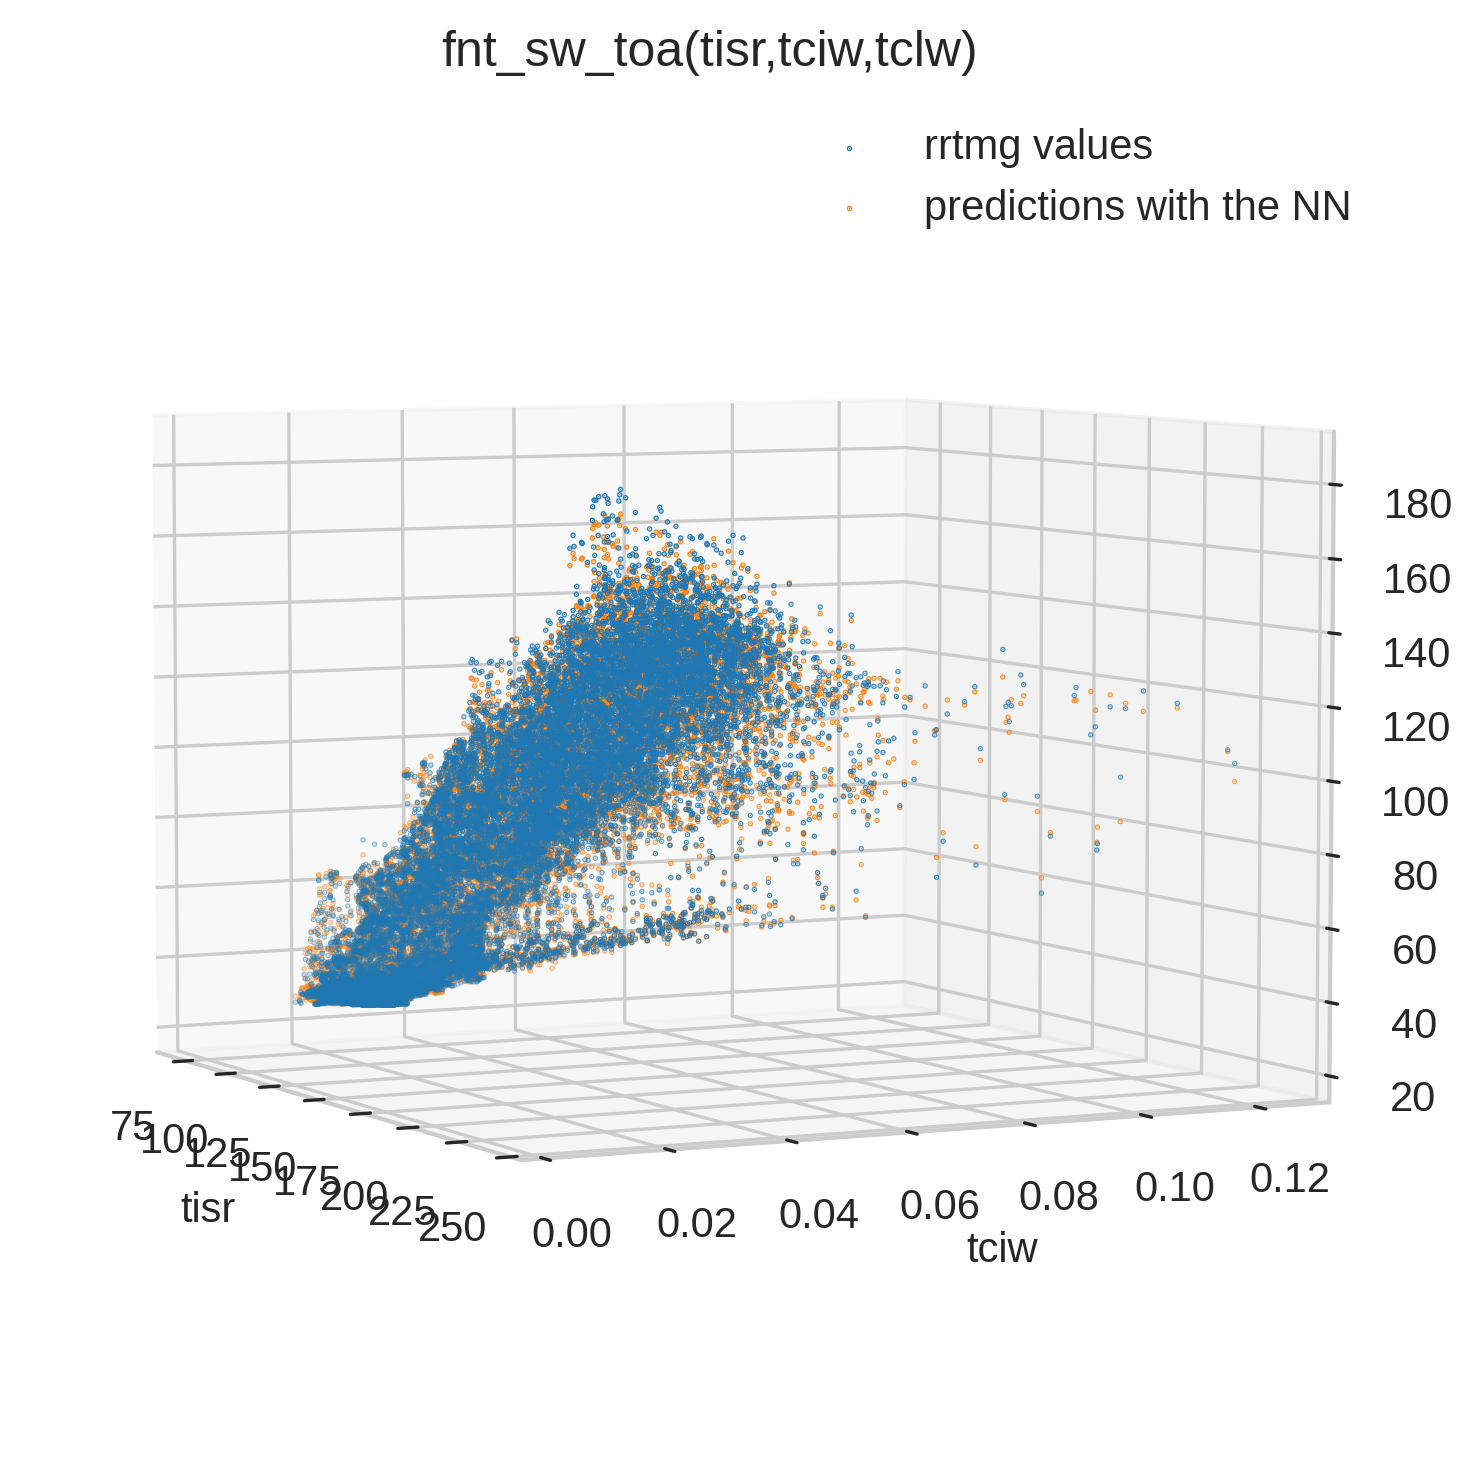

In [39]:
plt.figure(figsize=(6,6),dpi=300)

ax = plt.axes(projection='3d')
ax.scatter3D(I,II,Y,label='rrtmg values',s=0.1)
ax.scatter3D(I,II,prdctnss,label='predictions with the NN',s=0.1)

plt.legend(loc='upper right')
plt.title('fnt_sw_toa('+vars_list_str[0]+','+vars_list_str[1]+','+vars_list_str[2] +')')
plt.xlabel(vars_list_str[0])
plt.ylabel(vars_list_str[1])

ax.view_init(5, 333) #333

plt.show()

In [21]:
I = (df.eff_tau_ice+df.eff_tau_liq)
II = (df.eff_tau_ice+df.eff_tau_liq)*df.albedo
III = df.albedo

V = df.fnt_sw_toa #z_interp

In [ ]:
plt.figure(figsize=(6,6),dpi=300)

ax = plt.axes(projection='3d')
ax.scatter3D(I,II,V,label='rrtmg values',s=0.1)
ax.scatter3D(I,II,prdctnss,label='predictions with the NN',s=0.1)

plt.legend(loc='upper right')
plt.title('fnt_sw_toa('+vars_list_str[0]+','+vars_list_str[1]+','+vars_list_str[2] +')')
plt.xlabel(vars_list_str[0])
plt.ylabel(vars_list_str[1])

ax.view_init(5, 333) #333

plt.show()

In [48]:
#prueba = xr.open_dataset(data_path+variables[7].upper()+'_era5.nc')